# Atividade prática Redes Neurais Covolucionais
## Visão Computacional Aplicada a Testes
------------------------------------------------------------
# Aluno: Ivson de Lima Santos 
------------------------------------------------------------

Para resolver este problema de classificação foi usado a arquitetura ResNet-50, segue a baixo a explicação das etapas do código:

# Pré-processamento dos dados:
- As imagens de entrada passam por uma série de transformações, como redimensionamento, corte central, espelhamento horizontal, conversão para tensores e normalização.

# Configuração dos DataLoaders:
- Os conjuntos de dados (treinamento, validação e teste) são divididos e carregados em lotes usando os DataLoaders. Isso permite carregar os dados de forma eficiente durante o treinamento, processando-os em pequenos grupos.

# Definição e modificação do modelo ResNet-50:
- A arquitetura ResNet-50 pré-treinada é carregada e seus parâmetros são congelados para evitar o treinamento desnecessário. A camada totalmente conectada (fc) é modificada para se adequar ao problema de classificação.

# Treinamento do modelo:
- O modelo é treinado iterativamente por um número específico de épocas. O loop de treinamento itera sobre os lotes de treinamento, faz previsões com o modelo, calcula a perda, realiza a retropropagação e atualiza os parâmetros do modelo com base nos gradientes.

# Avaliação do modelo:
- Após cada época de treinamento, o modelo é avaliado no conjunto de validação. O loop de avaliação itera sobre os lotes de validação, faz previsões com o modelo e calcula a perda média.

# Visualização de resultados:
- Os gráficos das perdas de treinamento e validação são plotados para acompanhar o progresso do treinamento. Além disso, uma matriz de confusão é exibida para avaliar o desempenho do modelo em cada classe. O relatório de classificação         também é impresso, mostrando métricas como precisão, recall e f1-score para cada classe.

# Salvando o modelo treinado:
- Os parâmetros do modelo treinado são salvos em um arquivo "classifier.pt" para uso futuro.

Em resumo, este código realiza o pré-processamento dos dados, treina um modelo de classificação usando a arquitetura ResNet-50, avalia seu desempenho e fornece uma análise visual e numérica dos resultados.

In [1]:
!pip install torchsummary
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim, functional
from torch.utils import data

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from torchsummary import summary
import numpy as np

## Definição dos loops de treino e avaliação

In [2]:
'''A função train_loop é responsável por treinar o modelo, ajustando seus parâmetros 
com base nos dados de treinamento. Já a função evaluation_loop avalia o desempenho 
do modelo em um conjunto de dados de validação, calculando a perda média entre as 
previsões do modelo e os rótulos verdadeiros.'''

def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train()  # Define o modelo no modo de treinamento
    size = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X.to(device))  # Gera as previsões do modelo para o lote atual

        optimizer.zero_grad()  # Limpa os gradientes acumulados do otimizador

        loss = loss_fn(pred, y.to(device))  # Calcula a perda entre as previsões e os rótulos verdadeiros

        loss.backward()  # Realiza a retropropagação para calcular os gradientes

        optimizer.step()  # Atualiza os parâmetros do modelo com base nos gradientes

        train_loss += loss.item()  # Acumula a perda do lote atual

    train_loss /= size  # Calcula a perda média de treinamento
    print(f"Training loss: {train_loss:>7f}")  # Imprime a perda média de treinamento
    return train_loss


def evaluation_loop(dataloader, model, loss_fn, device, label="Validation"):
    model.eval()  # Define o modelo no modo de avaliação
    size = len(dataloader)
    loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))  # Gera as previsões do modelo para o lote atual
            loss += loss_fn(pred, y.to(device)).item()  # Calcula a perda entre as previsões e os rótulos verdadeiros

    loss /= size  # Calcula a perda média
    print(f"{label} loss: {loss:>8f} \n")  # Imprime a perda média com um rótulo específico
    return loss


## Definição de hiperparâmetros

In [3]:
'''
Aproveitando a GPU e a CPU do kaggle foi possível aumentar o lote de treinameto para que fosse mais rápido o treinamento do modelo.
'''
BATCH_SIZE_TR = 128  # Tamanho do lote de treinamento

'''
Foi escolhido um tamanho de lote menor para não utilizar muita memória já que é um recurso que é facilmente excedido.
'''
BATCH_SIZE_TS = 64   # Tamanho do lote de teste

'''
Determina o tamanho do passo que o algoritmo de otimização dá para ajustar os pesos do modelo durante o treinamento.
'''
LR = 5e-3  # Taxa de aprendizado
EPOCHS = 100  # Épocas de treinamento

## Datasets e DataLoaders

In [4]:
interpolation = transforms.InterpolationMode.NEAREST

preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=interpolation),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.446], std=[0.247, 0.243, 0.261])
])

In [5]:
import ssl 
ssl._create_default_https_context=ssl._create_unverified_context

In [6]:
base_euroSAT = datasets.EuroSAT('./data/', download=True,
    transform=preprocess
)
# A divisão de dados foi feita desta maneira:
#     100% = 27000
#     80%      20%     (treino e validação) e (teste) respectivamente.
#    21600    5400     resultado das porcentagens
# 15120 6480           divisão--> Treino: 15120(70%) Validação: 6480(30%) 
#  70%  30%            
train_ds, val_ds, test_ds = data.random_split(base_euroSAT, [15120, 6480, 5400])


100%|██████████| 94280567/94280567 [00:04<00:00, 22172356.36it/s]


Extracting ./data/eurosat/EuroSAT.zip to ./data/eurosat


In [7]:
'''Esse código cria DataLoaders para carregar os dados de treinamento, validação 
e teste em lotes durante o treinamento de um modelo de aprendizado de máquina. 
Os DataLoaders garantem um carregamento eficiente dos dados, processando-os em 
pequenos grupos. Isso ajuda o modelo a aprender melhor, evitando padrões indesejados 
e introduzindo aleatoriedade no treinamento.'''

# Criação do DataLoader para os dados de treinamento
train_dl = data.DataLoader(
    train_ds,                   # Dataset de treinamento
    num_workers=2,              # Número de processos para carregamento paralelo
    pin_memory=True,            # Copia dados para memória CUDA
    batch_size=BATCH_SIZE_TR,   # Tamanho do lote (número de amostras) por iteração
    shuffle=True                # Embaralha os dados a cada época de treinamento
)

# Criação do DataLoader para os dados de validação
val_dl = data.DataLoader(
    val_ds,                     # Dataset de validação
    num_workers=2,              # Número de processos para carregamento paralelo
    pin_memory=True,            # Copia dados para memória CUDA
    batch_size=BATCH_SIZE_TS,   # Tamanho do lote (número de amostras) por iteração
    shuffle=True                # Embaralha os dados a cada época de validação
)

# Criação do DataLoader para os dados de teste
test_dl = data.DataLoader(
    test_ds,                    # Dataset de teste
    num_workers=2,              # Número de processos para carregamento paralelo
    pin_memory=True,            # Copia dados para memória do pino CUDA
    batch_size=BATCH_SIZE_TS,   # Tamanho do lote (número de amostras) por iteração
    shuffle=True                # Embaralha os dados a cada execução de teste
)


In [8]:
# Dicionário com os nomes dos rótulos
label_dict = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake",
}

In [9]:
# Obter uma iteração dos dados de teste
instances, targets = next(iter(test_dl))

In [10]:
# Verificar as dimensões das instâncias e alvos
instances.shape, targets.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [11]:
# Definindo uma transformação para inverter a normalização dos dados
invTrans = transforms.Normalize(mean=[-0.491 / 0.247, -0.482 / 0.243, -0.446 / 0.261],
                                std=[1 / 0.247, 1 / 0.243, 1 / 0.261])

In [12]:
# Aplicando a transformação invTrans nas instâncias
ins = invTrans(instances)

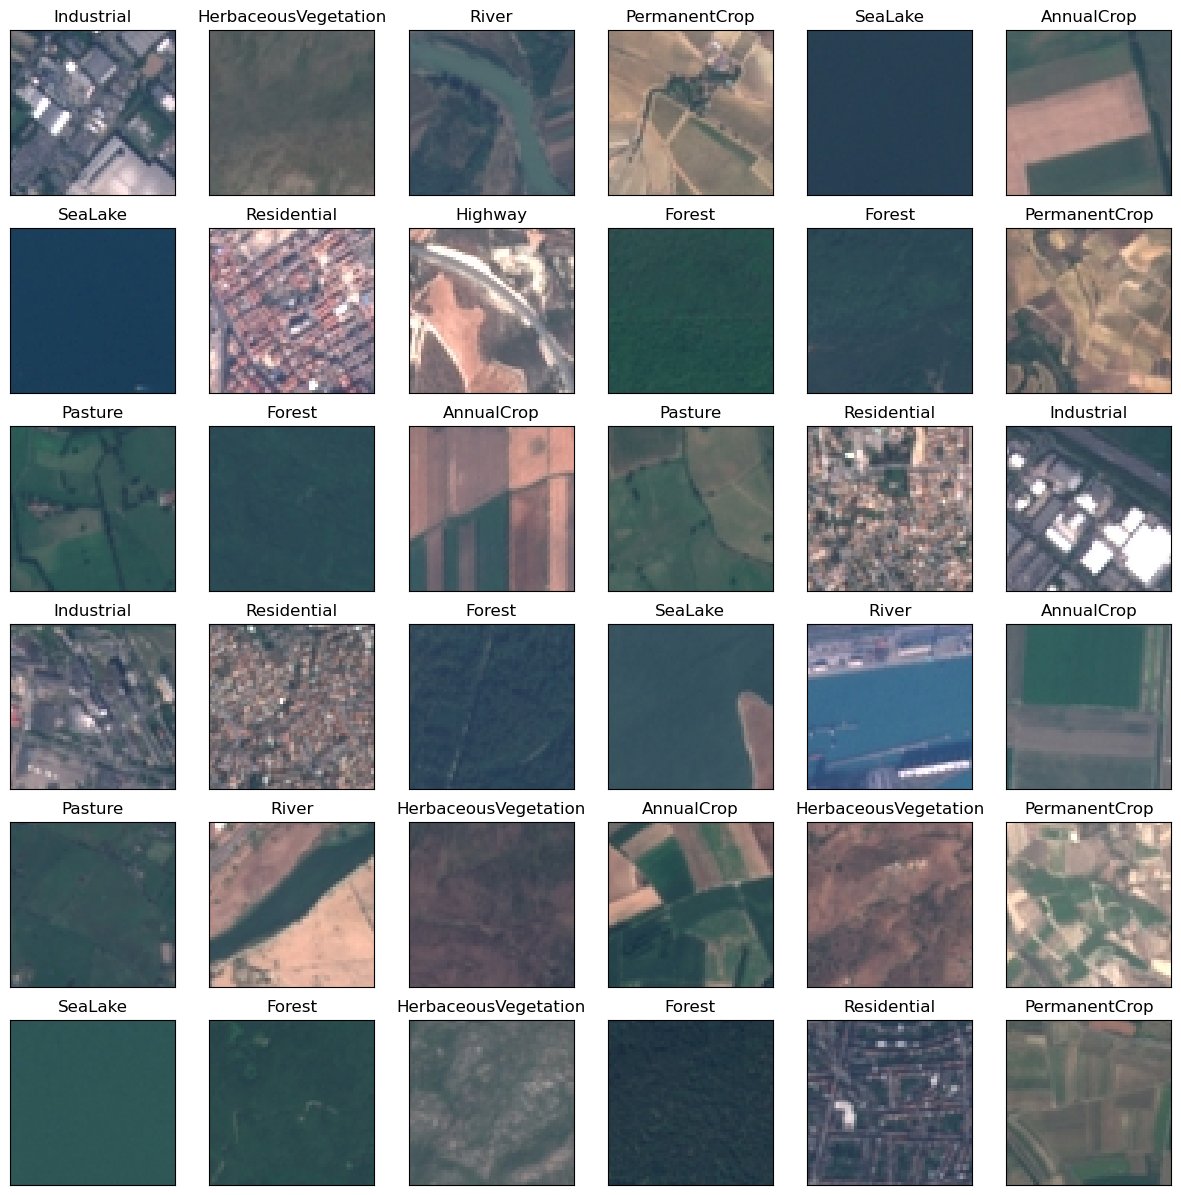

In [13]:
'''Este código exibe uma matriz de subplots, onde cada subplot mostra uma imagem 
das instâncias de dados e seu rótulo correspondente. É uma forma de visualizar as 
imagens e seus rótulos em uma grade organizada.'''

# Definindo o número de subplots
w = 6

# Criando a figura e os eixos dos subplots
fig, ax = plt.subplots(w, w, figsize=(15, 15))

# Iterando sobre os subplots
for i in range(w):
    for j in range(w):
        # Exibindo a imagem nas coordenadas (i, j)
        ax[i][j].imshow(ins[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        
        # Obtendo o rótulo da imagem
        label = targets[i * w + j].item()
        
        # Configurando o título do subplot com o rótulo correspondente
        ax[i][j].set_title(label_dict[label])
        
        # Removendo as marcações dos eixos x e y
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

In [14]:
del instances, targets, ins

## ResNet

# Profundidade:
- A profundidade foi mantida a mesma, pois estamos carregando uma versão pré-treinada da arquitetura original. A ResNet-50 já é uma rede profunda, composta por 50 camadas, e carregá-la pré-treinada significa que ela já foi treinada em uma grande quantidade de dados e aprendeu representações úteis de características visuais.

# Funções de ativação: 
- Foi escolhido a função de ativação ReLU que é uma função que introduz não linearidade na rede, permitindo que ela aprenda representações mais complexas dos dados.

# Estrutura da camada totalmente conectada (fc): 
- Na modificação da ResNet-50, substituímos a camada totalmente conectada original (fc) por uma nova sequência de camadas. A camada inicial é uma camada linear que recebe as características de saída da ResNet original (resnet.fc.in_features) e as reduz para 16 dimensões, este número de dimensões foi escolhido aleatoriamente e testado afim de encontrar um bom resultado, diminuir as dimensões pode ajudar na questão do processamento, pois as características mais marcantes. Em seguida, adicionamos uma camada ReLU que introduz não linearidade. Finalmente, foi adicionada uma última camada linear que reduz as 16 dimensões para as 10 classes de destino.

In [15]:
'''Foi carregada a arquitetura pré-treinada da ResNet-50 e congelado seus parâmetros. 
Em seguida, eu modifico a camada totalmente conectada para se adequar à tarefa de 
classificação, utilizando duas camadas lineares e uma função de ativação ReLU.'''

# Carregar a arquitetura ResNet-50 pré-treinada
resnet = models.resnet50(pretrained=True)

# Congelar os parâmetros existentes para evitar o treinamento
for param in resnet.parameters():
    param.requires_grad_(False)

# Modificar a camada totalmente conectada (fc) para a classificação
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

# Retornar o modelo ResNet-50 modificado
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
# Verificar a disponibilidade da GPU e definir o dispositivo de execução
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
# Mover o modelo ResNet para o dispositivo de execução especificado
classifier = resnet.to(device)
classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# Verificação de carregamento do modelo
load_model = False

# Verificar se deve carregar um modelo pré-treinado
if load_model:
    # Carregar os pesos do modelo a partir de um arquivo .pt
    classifier.load_state_dict(torch.load(input("Path to .pt file: ")))

In [19]:
# Gerar um resumo do modelo classifier
summary(classifier, (3, 224, 224), batch_size=BATCH_SIZE_TR, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

## Definição da função de perda e otimizador


# Função de perda: 
    - O problema do EUROSAT envolve classificar imagens em uma das 10 classes diferentes. A função nn.CrossEntropyLoss() é especialmente adequada para esse tipo de problema, onde cada amostra pode pertencer a apenas uma classe.
# Otimizador:
    - Para conjuntos de dados grandes, como imagens de satélite (problema abordado usando o dataset EUROSAT). O SGD atualiza os parâmetros do modelo iterativamente usando pequenos subconjuntos aleatórios dos dados de treinamento, o que torna o processo computacionalmente eficiente.

In [20]:
# Definir a função de perda
loss_fn = nn.CrossEntropyLoss()

# Definir o otimizador
optimizer = optim.SGD(classifier.parameters(), lr=LR)

## Treinamento

In [21]:
# Inicializar listas vazias para armazenar as perdas de treinamento e validação
train_losses = []
val_losses = []

# Loop de épocas
for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")
    
    # Executar o loop de treinamento e registrar a perda de treinamento
    train_loss = train_loop(train_dl, classifier, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    
    # Executar o loop de avaliação no conjunto de validação e registrar a perda de validação
    val_loss = evaluation_loop(val_dl, classifier, loss_fn, device)
    val_losses.append(val_loss)


Epoch: 1/100
Training loss: 2.150033
Validation loss: 1.983495 

Epoch: 2/100
Training loss: 1.804851
Validation loss: 1.624082 

Epoch: 3/100
Training loss: 1.437176
Validation loss: 1.274665 

Epoch: 4/100
Training loss: 1.143538
Validation loss: 1.031252 

Epoch: 5/100
Training loss: 0.945858
Validation loss: 0.864041 

Epoch: 6/100
Training loss: 0.809620
Validation loss: 0.756109 

Epoch: 7/100
Training loss: 0.721491
Validation loss: 0.680836 

Epoch: 8/100
Training loss: 0.655003
Validation loss: 0.619399 

Epoch: 9/100
Training loss: 0.603135
Validation loss: 0.573672 

Epoch: 10/100
Training loss: 0.558766
Validation loss: 0.537789 

Epoch: 11/100
Training loss: 0.522646
Validation loss: 0.498457 

Epoch: 12/100
Training loss: 0.493512
Validation loss: 0.474860 

Epoch: 13/100
Training loss: 0.469848
Validation loss: 0.454673 

Epoch: 14/100
Training loss: 0.440842
Validation loss: 0.431022 

Epoch: 15/100
Training loss: 0.424907
Validation loss: 0.415267 

Epoch: 16/100
Train

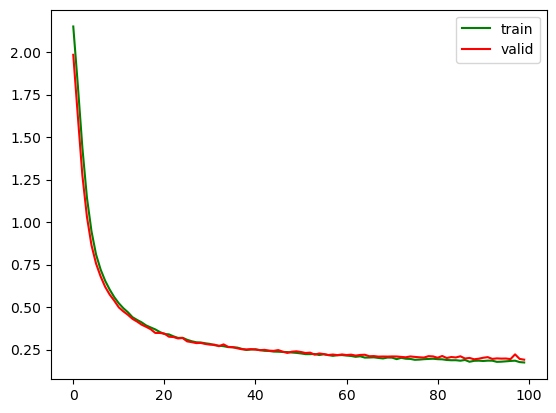

In [29]:
# Criar uma nova figura para o gráfico
fig = plt.figure()

# Plotar as perdas de treinamento e validação
plt.plot(train_losses, c="g", label="train")
plt.plot(val_losses, c="r", label="valid")

# Adicionar legenda ao gráfico
plt.legend()

# Ánalise do gráfico de valores de perda

Neste gráfico é possível observar que o valor de perda diminue a cada época, indicando que o modelo está aprendendo, também é possível observar que não há uma diferença significativa entre o valor da função de perda no treinamento e na validação. Isso indica que o modelo está generalizando bem para dados não vistos. Logo é possível resumir que não há indicios de underfitting ou overfitting.

## Teste e avaliação do desempenho

In [30]:
# Inicializar listas vazias para armazenar as previsões e os alvos
all_preds = []
all_targets = []

# Inicializar contadores para calcular a precisão total
total_corrects = 0
total_n = 0

# Colocar o modelo em modo de avaliação
classifier.eval()

# Loop pelos lotes de teste
for instances, targets in test_dl:
    # Mover os dados para o dispositivo
    instances, targets = instances.to(device), targets.to(device)
    
    # Desabilitar o cálculo dos gradientes
    with torch.no_grad():
        # Obter as previsões do modelo
        preds = classifier(instances)
        
    # Aplicar a função softmax às previsões e obter a classe com maior probabilidade
    preds = nn.functional.softmax(preds, dim=1)
    preds = torch.argmax(preds, 1)
    
    # Calcular a quantidade de previsões corretas e o total de exemplos
    total_corrects += (preds == targets).sum().item()
    total_n += len(instances)
    
    # Armazenar as previsões e os alvos para avaliação posterior
    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(targets.unsqueeze(-1))

In [31]:
# Calcular a precisão (acurácia) no conjunto de teste
acc = total_corrects / total_n

# Imprimir a precisão no formato de porcentagem
print(f"Test Accuracy: {100 * acc:.2f}%")

Test Accuracy: 94.11%


In [32]:
# Concatenar todas as previsões e alvos em tensores
preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

# Obter as dimensões dos tensores de previsões e alvos
preds.shape, targets.shape

(torch.Size([5400]), torch.Size([5400]))

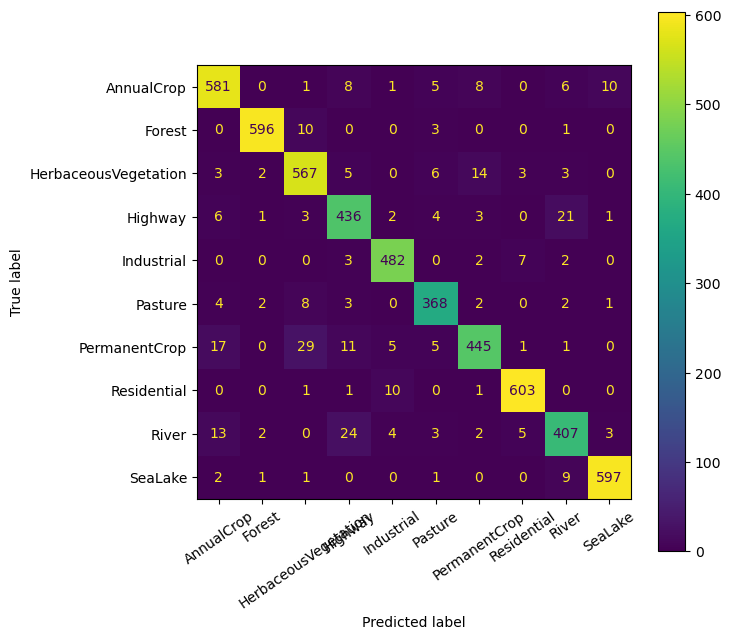

In [33]:
# Criar uma figura e um eixo para exibir a matriz de confusão
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.grid(False)

# Obter a lista de rótulos das classes
labels = list(label_dict.values())

# Calcular a matriz de confusão
cm = confusion_matrix(targets, preds)

# Criar uma representação visual da matriz de confusão
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [34]:
# Imprimir o relatório de classificação
print(classification_report(targets, preds, target_names=labels, zero_division=0))

                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.94      0.93       620
              Forest       0.99      0.98      0.98       610
HerbaceousVegetation       0.91      0.94      0.93       603
             Highway       0.89      0.91      0.90       477
          Industrial       0.96      0.97      0.96       496
             Pasture       0.93      0.94      0.94       390
       PermanentCrop       0.93      0.87      0.90       514
         Residential       0.97      0.98      0.98       616
               River       0.90      0.88      0.89       463
             SeaLake       0.98      0.98      0.98       611

            accuracy                           0.94      5400
           macro avg       0.94      0.94      0.94      5400
        weighted avg       0.94      0.94      0.94      5400



# Resultados 
- **F1**: Neste resultado é possível observar que varia entre 0.88 à 0.98 e o **F1 médio** foi de: 0.93
- **Acurácia**: Foi possível observar que a acurácia atingiu o valor de 93.57%

In [35]:
# Salvar os parâmetros do modelo treinado
torch.save(classifier.state_dict(), "classifier.pt")